In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [6]:
trainlabels = pd.read_csv("/kaggle/input/cifar-10/trainLabels.csv")

In [7]:
display(trainlabels)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
...,...,...
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile


In [27]:
#!pip install py7zr

In [9]:
import py7zr
temp_path = '/kaggle/temp/'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)
train_file_path = '/kaggle/input/cifar-10/train.7z'
archive = py7zr.SevenZipFile(train_file_path, mode='r')
archive.extractall(path=temp_path)
archive.close()

In [12]:
test_path = '/kaggle/test/'
if not os.path.exists(test_path):
    os.mkdir(test_path)
test_file_path = '/kaggle/input/cifar-10/test.7z'
archive_test = py7zr.SevenZipFile(test_file_path, mode='r')
archive_test.extractall(path=test_path)
archive_test.close()

KeyboardInterrupt: decoding with 'utf-16LE' codec failed (KeyboardInterrupt: )

In [13]:
train_data = os.path.join(temp_path,'train')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

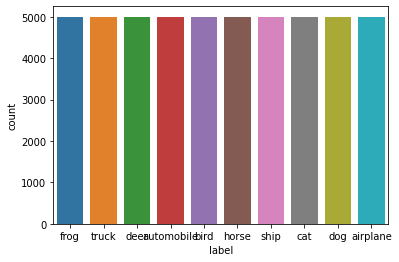

In [14]:
sns.countplot(trainlabels['label'])

In [30]:
def append_ext(fn):
    return "/kaggle/temp/train/"+str(fn)+'.png'

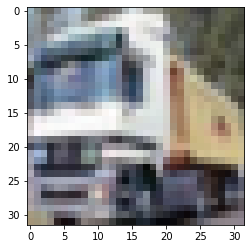

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/kaggle/temp/train/2.png')
imgplot = plt.imshow(img)
plt.show()

In [57]:
trainlabels['path'] = trainlabels['id']
trainlabels['path'] = trainlabels['path'].apply(append_ext)
datagen=ImageDataGenerator(rotation_range=15,width_shift_range=4,height_shift_range=4, validation_split=0.3, rescale=1./255.)
bs=64

In [58]:
trainlabels.head()

,id,label,path
0,1,frog,/kaggle/temp/train/1.png
1,2,truck,/kaggle/temp/train/2.png
2,3,truck,/kaggle/temp/train/3.png
3,4,deer,/kaggle/temp/train/4.png
4,5,automobile,/kaggle/temp/train/5.png


In [59]:
os.path.isfile('/kaggle/working/train/3.png')

False

In [60]:
bs

64

In [61]:
train_generator=datagen.flow_from_dataframe(
                        dataframe=trainlabels,
                        x_col="path",
                        y_col="label",
                        batch_size=bs,
                        seed=42,
                        subset = 'training',
                        shuffle=True,
                        validation_plit = 0.3,
                        class_mode="categorical",
                        target_size =  (32,32))


Found 35000 validated image filenames belonging to 10 classes.


In [62]:
next(train_generator)[1]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

In [63]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [64]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [67]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=1, batch_size = bs)

547/547 [==============================] - 47s 84ms/step - loss: 9.6787 - accuracy: 0.1012


# Sample submission

In [69]:
pd.read_csv('/kaggle/input/cifar-10/sampleSubmission.csv')

,id,label
0,1,cat
1,2,cat
2,3,cat
3,4,cat
4,5,cat
...,...,...
299995,299996,cat
299996,299997,cat
299997,299998,cat
299998,299999,cat


In [70]:
import shutil
from py7zr import unpack_7zarchive
shutil.register_unpack_format('7zip',['.7z'],unpack_7zarchive)
shutil.unpack_archive('/kaggle/input/cifar-10/test.7z','/kaggle/temp/test')
shutil.unregister_unpack_format('7zip')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(directory='/kaggle/temp/test',target_size=(32,32),batch_size=64,class_mode=None,shuffle=False)

Found 300000 images belonging to 1 classes.


In [71]:
test_gen.reset()
predictions_vecs = model.predict(test_gen)

predictions_final = np.argmax(predictions_vecs, axis=1)

In [72]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print(cifar10_classes)
predicted_classes=np.empty(shape=300000,dtype=np.dtype('U20'))

ind=0
for i in predictions_final.tolist():
    predicted_classes[ind]=cifar10_classes[i]
    ind=ind+1
    
filenames_wo_ext = []
for fname in test_gen.filenames:
    filenames_wo_ext.append(int(fname.split(sep="/")[1].split(sep=".")[0])-1)

predicted_classes_final = np.empty(shape=300000,dtype=np.dtype('U20'))
predicted_classes_final[filenames_wo_ext]=predicted_classes

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [73]:
sub = pd.read_csv('../input/cifar-10/sampleSubmission.csv',header='infer')
sub.info()

sub['label'] = predicted_classes_final
sub.to_csv('submission.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      300000 non-null  int64 
 1   label   300000 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.6+ MB
